[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sonder-art/ia_p26/blob/main/clase/07_optimization/notebooks/03_tarea_optimizacion.ipynb)

# Tarea 7: Optimización (20 puntos)

**Entrega:** Lunes 23 de febrero, 2026
**Formato:** Pull request en `estudiantes/<tu-usuario>/tarea_07/` + Canvas

## Instrucciones

Para **cada** problema (5 en total, 4 pts c/u):

| Pts | Qué hacer |
|:---:|-----------|
| 1 | **Formulación matemática** — escribe variables de decisión, función objetivo y restricciones en LaTeX |
| 1 | **Elección de optimizador** — elige el método/solver y explica por qué es adecuado |
| 1 | **Implementación** — completa las funciones esqueleto (las que tienen `raise NotImplementedError`) |
| 1 | **Solución y visualización** — ejecuta, reporta el resultado y visualiza |

**Reglas:**
- Completa SOLO las celdas marcadas con `raise NotImplementedError`
- NO modifiques las celdas de datos
- Escribe la matemática en LaTeX dentro de las celdas markdown indicadas
- Cada función tiene documentación con los inputs/outputs esperados

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import (minimize, minimize_scalar, linprog, milp,
                            LinearConstraint, Bounds,
                            dual_annealing, differential_evolution)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

---
## Problema 1: Nutrición animal (4 puntos)

Un ganadero necesita formular la **dieta diaria** para su ganado. Dispone de 6 ingredientes, cada uno con un costo por kilogramo y un perfil nutricional conocido (energía, proteína, calcio, fósforo).

La dieta debe cumplir **requerimientos mínimos** de cada nutriente, y el **consumo total** debe estar entre 8 y 12 kg por animal. Cada ingrediente tiene un **límite máximo** de inclusión.

El objetivo es **minimizar el costo total** de la dieta diaria por animal.

| Ingrediente | Costo (\$/kg) | Energía (Mcal/kg) | Proteína (g/kg) | Calcio (g/kg) | Fósforo (g/kg) | Max (kg) |
|:-----------:|:------------:|:-----------------:|:---------------:|:------------:|:--------------:|:--------:|
| Maíz        | 4.5          | 3.3               | 90              | 0.3          | 2.8            | 6.0      |
| Soya        | 9.0          | 3.2               | 440             | 2.7          | 6.5            | 3.0      |
| Heno        | 2.5          | 2.0               | 80              | 4.0          | 2.0            | 5.0      |
| Melaza      | 3.0          | 2.8               | 40              | 8.0          | 0.8            | 2.0      |
| Minerales   | 15.0         | 0.0               | 0               | 200.0        | 80.0           | 0.5      |
| Salvado     | 3.5          | 2.5               | 150             | 1.5          | 12.0           | 4.0      |

**Requerimientos mínimos diarios por animal:** Energía >= 25 Mcal, Proteína >= 1000 g, Calcio >= 30 g, Fósforo >= 20 g

**Consumo total:** entre 8 y 12 kg

### 1.1 Formulacion matematica

**Variables de decision:**

$$x_i \geq 0 \quad i = 1,\ldots,6$$

donde $x_i$ es la cantidad en kg del ingrediente $i$ (Maíz, Soya, Heno, Melaza, Minerales, Salvado) incluida en la dieta diaria.

**Funcion objetivo:**

$$\min_{x} \quad \mathbf{c}^\top \mathbf{x} = 4.5x_1 + 9.0x_2 + 2.5x_3 + 3.0x_4 + 15.0x_5 + 3.5x_6$$

**Restricciones:**

$$\begin{aligned}
& \sum_{i=1}^{6} n_{ki} \, x_i \geq r_k \quad \forall k \in \{\text{energía, proteína, calcio, fforo}\} \\
& 8 \leq \sum_{i=1}^{6} x_i \leq 12 \\
& 0 \leq x_i \leq u_i \quad i=1,\ldots,6
\end{aligned}$$

donde $n_{ki}$ es el contenido del nutriente k por kg del ingrediente $i$, $r_k$ es el requerimiento mínimo del nutriente $k$, y $u_i$ es el máximo de kg permitido del ingrediente $i$.

### 1.2 Eleccion de optimizador

**Optimizador elegido:** `scipy.optimize.linprog`

**Justificacion:** El problema de nutrición animal es un programa lineal (LP): la función objetivo y todas las restricciones son lineales en las variables de decisión $x_i$. `linprog` de SciPy está diseñado exactamente para este tipo de problemas, garantizando encontrar el óptimo global de forma eficiente mediante el método simplex.

In [4]:
# === DATOS PROBLEMA 1 (NO MODIFICAR) ===
nombres_p1 = ["Maiz", "Soya", "Heno", "Melaza", "Minerales", "Salvado"]
costos_p1 = np.array([4.5, 9.0, 2.5, 3.0, 15.0, 3.5])

# Contenido nutricional por kg: filas = [energia, proteina, calcio, fosforo]
nutrientes_p1 = np.array([
    [3.3, 3.2, 2.0, 2.8, 0.0, 2.5],   # energia (Mcal/kg)
    [90,  440, 80,  40,  0,   150],     # proteina (g/kg)
    [0.3, 2.7, 4.0, 8.0, 200, 1.5],    # calcio (g/kg)
    [2.8, 6.5, 2.0, 0.8, 80,  12.0],   # fosforo (g/kg)
])
nombres_nutrientes_p1 = ["Energia (Mcal)", "Proteina (g)", "Calcio (g)", "Fosforo (g)"]
req_min_p1 = np.array([25.0, 1000.0, 30.0, 20.0])
max_kg_p1 = np.array([6.0, 3.0, 5.0, 2.0, 0.5, 4.0])
intake_min_p1, intake_max_p1 = 8.0, 12.0

In [ ]:
# === IMPLEMENTACION PROBLEMA 1 ===

def objetivo_p1(x):
    """Calcula el costo total de la dieta.
    """
    return float(costos_p1 @ x)


def verificar_p1(x):
    """Verifica si la solucion cumple todas las restricciones
    """
    nutrientes_totales = nutrientes_p1 @ x
    intake_total = float(x.sum())
    factible = (
        np.all(nutrientes_totales >= req_min_p1) and
        intake_min_p1 <= intake_total <= intake_max_p1 and
        np.all(x >= 0) and
        np.all(x <= max_kg_p1)
    )
    return {
        'factible': factible,
        'nutrientes_totales': nutrientes_totales,
        'intake_total': intake_total
    }


def resolver_p1():
    """Resuelve el problema ya ejecuta todo
    """
    from scipy.optimize import linprog

    n = len(costos_p1)

    # Restricciones de nutrientes

    A_ub = -nutrientes_p1          # (4, 6)
    b_ub = -req_min_p1             # (4,)

    # Restriccion de intake total: sum(x) <= 12  y  sum(x) >= 8 => -sum(x) <= -8
    ones = np.ones((1, n))
    A_ub = np.vstack([A_ub, ones, -ones])
    b_ub = np.concatenate([b_ub, [intake_max_p1], [-intake_min_p1]])

    bounds = [(0, max_kg_p1[i]) for i in range(n)]

    res = linprog(costos_p1, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    x_opt = res.x
    costo_opt = res.fun
    return x_opt, costo_opt


Solucion P1:
  Maiz: 0.407 kg
  Soya: 0.000 kg
  Heno: 5.000 kg
  Melaza: 2.000 kg
  Minerales: 0.000 kg
  Salvado: 3.222 kg
Costo total: $31.61
Intake total: 10.63 kg
Factible: True


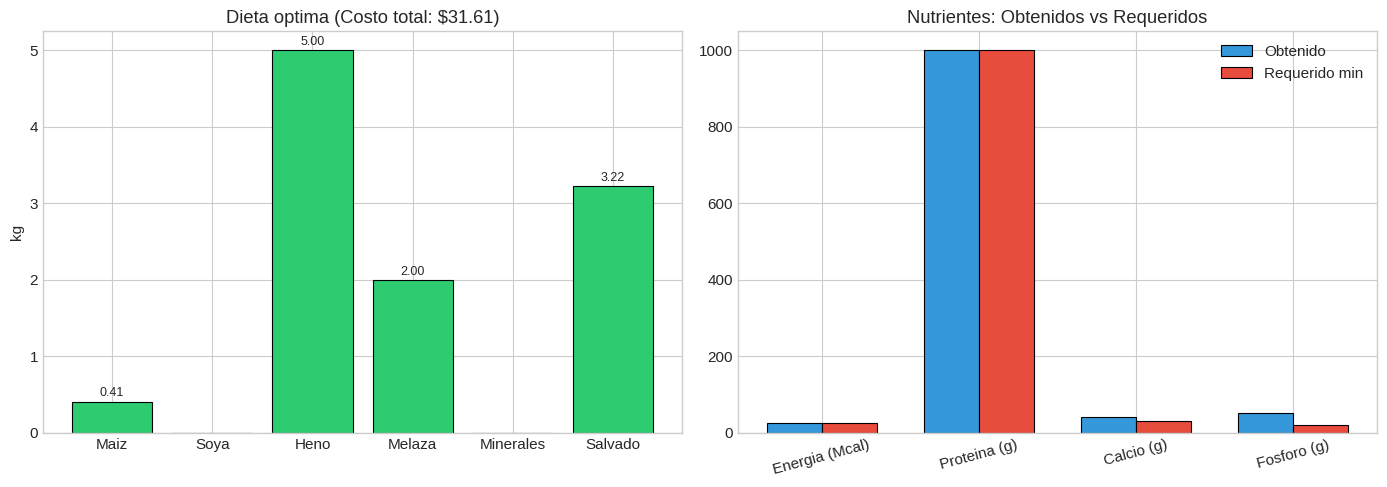

In [8]:
# === EJECUTAR Y VISUALIZAR PROBLEMA 1 ===

def plot_p1(x_opt, costo_opt):
    """Visualiza la solucion del problema de nutricion."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # kg por ingrediente
    ax = axes[0]
    colors = ['#2ecc71' if x > 0 else '#ecf0f1' for x in x_opt]
    bars = ax.bar(nombres_p1, x_opt, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_ylabel('kg')
    ax.set_title(f'Dieta optima (Costo total: ${costo_opt:.2f})')
    for bar, v in zip(bars, x_opt):
        if v > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                    f'{v:.2f}', ha='center', va='bottom', fontsize=9)

    # nutrientes obtenidos vs requeridos
    ax = axes[1]
    info = verificar_p1(x_opt)
    obtenidos = info['nutrientes_totales']
    x_pos = np.arange(len(nombres_nutrientes_p1))
    width = 0.35
    ax.bar(x_pos - width/2, obtenidos, width, label='Obtenido', color='#3498db', edgecolor='black', linewidth=0.8)
    ax.bar(x_pos + width/2, req_min_p1, width, label='Requerido min', color='#e74c3c', edgecolor='black', linewidth=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(nombres_nutrientes_p1, rotation=15)
    ax.set_title('Nutrientes: Obtenidos vs Requeridos')
    ax.legend()

    plt.tight_layout()
    plt.show()


# Resolver y visualizar
x_opt_p1, costo_opt_p1 = resolver_p1()
info_p1 = verificar_p1(x_opt_p1)

print(f"Solucion P1:")
for nombre, kg in zip(nombres_p1, x_opt_p1):
    print(f"  {nombre}: {kg:.3f} kg")
print(f"Costo total: ${costo_opt_p1:.2f}")
print(f"Intake total: {info_p1['intake_total']:.2f} kg")
print(f"Factible: {info_p1['factible']}")

plot_p1(x_opt_p1, costo_opt_p1)


---
## Problema 2: Portafolio de inversion (4 puntos)

Un inversionista tiene capital para distribuir entre 5 activos financieros. Cada activo tiene un **rendimiento esperado** y una **covarianza** conocida con los demas activos (ver datos).

El objetivo es **minimizar el riesgo** del portafolio (medido como la varianza del rendimiento), sujeto a:
- El rendimiento esperado del portafolio debe ser **al menos 8%**
- Todo el capital debe invertirse (las proporciones suman 1)
- No se permiten ventas en corto (todas las proporciones >= 0)
- Ningun activo puede representar mas del **40%** del portafolio

### 2.1 Formulacion matematica

**Variables de decision:**

$$\mathbf{w} = (w_1, w_2, w_3, w_4, w_5) \geq 0$$

donde $w_i$ es la proporción del capital invertido en el activo $i$.

**Funcion objetivo:**

$$\min_{\mathbf{w}} \quad \mathbf{w}^\top \Sigma \, \mathbf{w}$$

donde $\Sigma$ es la matriz de covarianza de los activos.

**Restricciones:**

$$\begin{aligned}
& \mathbf{r}^\top \mathbf{w} \geq 0.08 \quad \text{(rendimiento mínimo del 8\%)} \\
& \sum_{i=1}^{5} w_i = 1 \quad \text{(todo el capital invertido)} \\
& 0 \leq w_i \leq 0.40 \quad i=1,\ldots,5 \quad \text{(sin ventas en corto; máx 40\% por activo)}
\end{aligned}$$


### 2.2 Eleccion de optimizador

**Optimizador elegido:** `scipy.optimize.minimize` con método `SLSQP`

**Justificacion:** La función objetivo es cuadrática convexa ($\mathbf{w}^\top \Sigma \mathbf{w}$) y las restricciones son lineales, lo que hace que el problema sea un programa cuadrático convexo (QP) con un único mínimo global. SLSQP (Sequential Least Squares Programming) de SciPy maneja eficientemente restricciones de igualdad e inequalidad y es ideal para problemas QP de pequeña dimensión. La convexidad garantiza que el óptimo encontrado es global.

In [11]:
# === DATOS PROBLEMA 2 (NO MODIFICAR) ===
activos_p2 = ["Bonos gob.", "Acciones tech", "Bienes raices", "Materias primas", "Mercados emergentes"]
rendimientos_p2 = np.array([0.03, 0.14, 0.08, 0.11, 0.16])

cov_p2 = np.array([
    [0.0004, 0.0002, 0.0001, 0.0000, 0.0003],
    [0.0002, 0.0100, 0.0030, 0.0050, 0.0080],
    [0.0001, 0.0030, 0.0025, 0.0015, 0.0020],
    [0.0000, 0.0050, 0.0015, 0.0064, 0.0040],
    [0.0003, 0.0080, 0.0020, 0.0040, 0.0144],
])

retorno_minimo_p2 = 0.08
max_por_activo_p2 = 0.40

In [9]:
# === IMPLEMENTACION PROBLEMA 2 ===

def objetivo_p2(w):
    """Calcula la varianza (riesgo) del portafolio."""
    return float(w @ cov_p2 @ w)


def verificar_p2(w):
    """Verifica si el portafolio cumple todas las restricciones."""
    rendimiento = float(rendimientos_p2 @ w)
    varianza = objetivo_p2(w)
    suma_pesos = float(w.sum())
    factible = (
        rendimiento >= retorno_minimo_p2 - 1e-6 and
        abs(suma_pesos - 1.0) < 1e-4 and
        np.all(w >= -1e-6) and
        np.all(w <= max_por_activo_p2 + 1e-6)
    )
    return {
        'factible': factible,
        'rendimiento': rendimiento,
        'varianza': varianza,
        'suma_pesos': suma_pesos
    }


def resolver_p2():
    """Resuelve el problema de portafolio."""
    n = len(rendimientos_p2)
    w0 = np.ones(n) / n

    constraints = [
        {'type': 'eq',   'fun': lambda w: w.sum() - 1.0},
        {'type': 'ineq', 'fun': lambda w: rendimientos_p2 @ w - retorno_minimo_p2}
    ]
    bounds = [(0, max_por_activo_p2)] * n

    res = minimize(objetivo_p2, w0, method='SLSQP',
                   bounds=bounds, constraints=constraints,
                   options={'ftol': 1e-12, 'maxiter': 1000})

    return res.x, res.fun


Solucion P2:
  Bonos gob.: 32.6%
  Acciones tech: 0.0%
  Bienes raices: 35.9%
  Materias primas: 17.9%
  Mercados emergentes: 13.6%
Rendimiento esperado: 8.00%
Varianza: 0.001471
Desv. estandar: 3.84%
Factible: True


/tmp/ipykernel_8839/801631863.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(activos_p2, rotation=15)


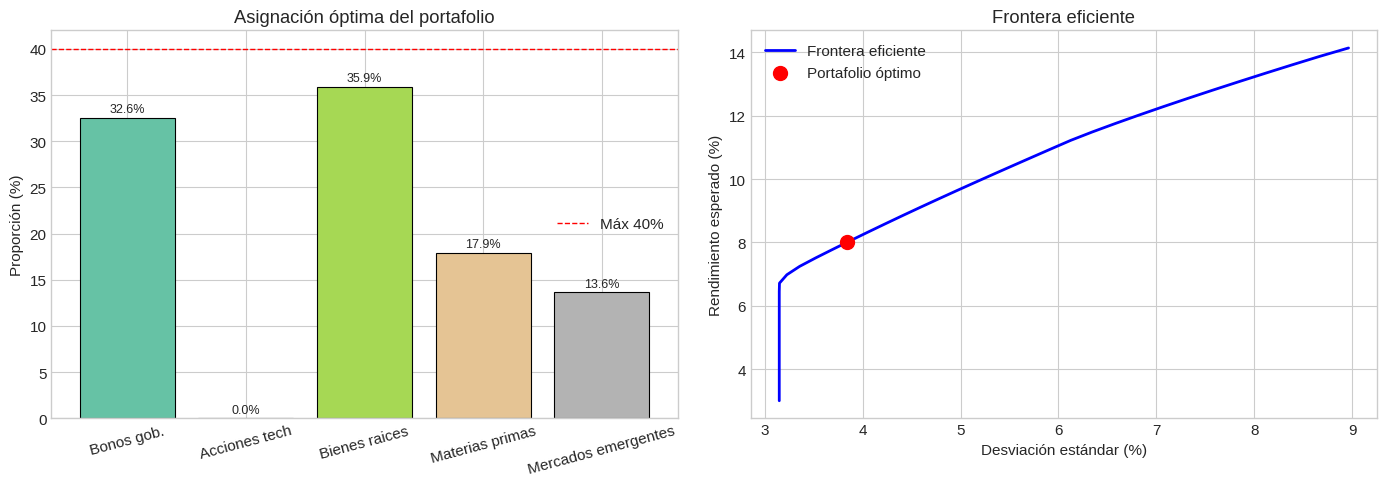

In [12]:
# === EJECUTAR Y VISUALIZAR PROBLEMA 2 ===

def plot_p2(w_opt, varianza_opt):
    """Visualiza la solucion del portafolio."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Panel 1: Asignacion del portafolio
    ax = axes[0]
    colors = plt.cm.Set2(np.linspace(0, 1, len(activos_p2)))
    bars = ax.bar(activos_p2, w_opt * 100, color=colors, edgecolor='black', linewidth=0.8)
    ax.axhline(40, color='red', linestyle='--', linewidth=1, label='Máx 40%')
    ax.set_ylabel('Proporción (%)')
    ax.set_title('Asignación óptima del portafolio')
    ax.set_xticklabels(activos_p2, rotation=15)
    for bar, v in zip(bars, w_opt):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{v*100:.1f}%', ha='center', va='bottom', fontsize=9)
    ax.legend()

    # Panel 2: Rendimiento vs Riesgo (frontera eficiente)
    ax = axes[1]
    # Generar frontera eficiente
    retornos_frontier = np.linspace(rendimientos_p2.min(), rendimientos_p2.max(), 50)
    varianzas_frontier = []
    for r_target in retornos_frontier:
        try:
            n = len(rendimientos_p2)
            w0 = np.ones(n) / n
            cons = [
                {'type': 'eq', 'fun': lambda w: w.sum() - 1.0},
                {'type': 'ineq', 'fun': lambda w, r=r_target: rendimientos_p2 @ w - r}
            ]
            bnds = [(0, max_por_activo_p2)] * n
            res = minimize(objetivo_p2, w0, method='SLSQP', bounds=bnds, constraints=cons,
                          options={'ftol': 1e-12})
            varianzas_frontier.append(np.sqrt(res.fun) * 100 if res.success else np.nan)
        except:
            varianzas_frontier.append(np.nan)

    ax.plot(varianzas_frontier, retornos_frontier * 100, 'b-', linewidth=2, label='Frontera eficiente')
    ax.scatter([np.sqrt(varianza_opt) * 100], [rendimientos_p2 @ w_opt * 100],
               color='red', s=100, zorder=5, label='Portafolio óptimo')
    ax.set_xlabel('Desviación estándar (%)')
    ax.set_ylabel('Rendimiento esperado (%)')
    ax.set_title('Frontera eficiente')
    ax.legend()

    plt.tight_layout()
    plt.show()


w_opt_p2, var_opt_p2 = resolver_p2()
info_p2 = verificar_p2(w_opt_p2)

print(f"Solucion P2:")
for activo, w in zip(activos_p2, w_opt_p2):
    print(f"  {activo}: {w*100:.1f}%")
print(f"Rendimiento esperado: {info_p2['rendimiento']*100:.2f}%")
print(f"Varianza: {var_opt_p2:.6f}")
print(f"Desv. estandar: {np.sqrt(var_opt_p2)*100:.2f}%")
print(f"Factible: {info_p2['factible']}")

plot_p2(w_opt_p2, var_opt_p2)


---
## Problema 3: Cobertura con antenas (4 puntos)

Una empresa de telecomunicaciones necesita dar cobertura de senal en **10 zonas** de una ciudad. Existen **7 ubicaciones** posibles para instalar torres de transmision. Cada torre tiene un costo de construccion y cubre un conjunto especifico de zonas (ver tabla).

El objetivo es **seleccionar que torres construir** para cubrir **todas las zonas** al **minimo costo** total. Cada torre se construye completamente o no se construye (decision binaria).

| Torre | Costo (miles \$) | Zonas que cubre |
|:-----:|:----------------:|:---------------:|
| T1    | 50               | 1, 2, 3         |
| T2    | 80               | 2, 3, 4, 5      |
| T3    | 60               | 4, 5, 6         |
| T4    | 70               | 5, 6, 7, 8      |
| T5    | 90               | 7, 8, 9, 10     |
| T6    | 40               | 1, 9, 10        |
| T7    | 75               | 3, 6, 7         |

### 3.1 Formulacion matematica

**Variables de decision:**

$$y_i \in \{0, 1\} \quad i = 1,\ldots,7$$

donde $y_i = 1$ si se construye la torre $i$, $y_i = 0$ no.

**Funcion objetivo:**

$$\min_{\mathbf{y}} \quad \mathbf{c}^\top \mathbf{y} = 50y_1 + 80y_2 + 60y_3 + 70y_4 + 90y_5 + 40y_6 + 75y_7$$

**Restricciones:**

$$\begin{aligned}
& \sum_{i=1}^{7} a_{ij} \, y_i \geq 1 \quad \forall j = 1,\ldots,10 \quad \text{(cada zona debe ser cubierta por al menos una torre)} \\
& y_i \in \{0, 1\} \quad i = 1,\ldots,7
\end{aligned}$$

donde $a_{ij} = 1$ si la torre $i$ cubre la zona $j$.

### 3.2 Eleccion de optimizador

**Optimizador elegido:** `scipy.optimize.milp` (Mixed Integer Linear Programming)

**Justificacion:** El problema de cobertura de conjuntos es un programa entero binario (BIP): la función objetivo y las restricciones son lineales, pero las variables deben ser enteras (0 o 1). `milp` de SciPy maneja directamente variables enteras usando el método Branch-and-Bound con relajación LP, garantizando encontrar el óptimo global. No se puede usar `linprog` porque la relajación continua puede dar soluciones fraccionarias que no son factibles en enteros.

In [14]:
# === DATOS PROBLEMA 3 (NO MODIFICAR) ===
n_torres_p3 = 7
n_zonas_p3 = 10
costos_torres_p3 = np.array([50, 80, 60, 70, 90, 40, 75])
nombres_torres_p3 = [f"T{i+1}" for i in range(n_torres_p3)]

# cobertura_p3[i, j] = 1 si torre i cubre zona j+1
cobertura_p3 = np.array([
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],  # T1: zonas 1,2,3
    [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # T2: zonas 2,3,4,5
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],  # T3: zonas 4,5,6
    [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],  # T4: zonas 5,6,7,8
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],  # T5: zonas 7,8,9,10
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],  # T6: zonas 1,9,10
    [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],  # T7: zonas 3,6,7
])

In [15]:
# === IMPLEMENTACION PROBLEMA 3 ===

def objetivo_p3(y):
    """Calcula el costo total de las torres seleccionadas."""
    return float(costos_torres_p3 @ y)


def verificar_p3(y):
    """Verifica si la seleccion de torres cubre TODAS las zonas."""
    cobertura = cobertura_p3.T @ y  # (10,) -- cuantas torres cubren cada zona
    zonas_cubiertas = [j+1 for j in range(n_zonas_p3) if cobertura[j] >= 1]
    zonas_sin_cubrir = [j+1 for j in range(n_zonas_p3) if cobertura[j] < 1]
    return {
        'factible': len(zonas_sin_cubrir) == 0,
        'zonas_cubiertas': zonas_cubiertas,
        'zonas_sin_cubrir': zonas_sin_cubrir
    }


def resolver_p3():
    """Resuelve el problema de cobertura con antenas."""
    from scipy.optimize import milp, LinearConstraint, Bounds

    n = n_torres_p3

    # Minimizar costos_torres_p3 @ y
    c = costos_torres_p3.astype(float)

    # cobertura_p3.T @ y >= 1 para cada zona

    A = cobertura_p3.T.astype(float)  # (10, 7)
    constraint = LinearConstraint(A, lb=1, ub=np.inf)

    # Bounds: 0 <= y_i <= 1
    bounds = Bounds(lb=0, ub=1)

    # Variables enteras en índices.
    integrality = np.ones(n)  # 1 = integer

    res = milp(c, constraints=constraint, integrality=integrality, bounds=bounds)

    y_opt = np.round(res.x).astype(int)
    costo_opt = objetivo_p3(y_opt)
    return y_opt, costo_opt


Solucion P3:
  T2: Construir (costo=$80k, cubre zonas [2, 3, 4, 5])
  T4: Construir (costo=$70k, cubre zonas [5, 6, 7, 8])
  T6: Construir (costo=$40k, cubre zonas [1, 9, 10])
Costo total: $190k
Factible: True
Zonas sin cubrir: []


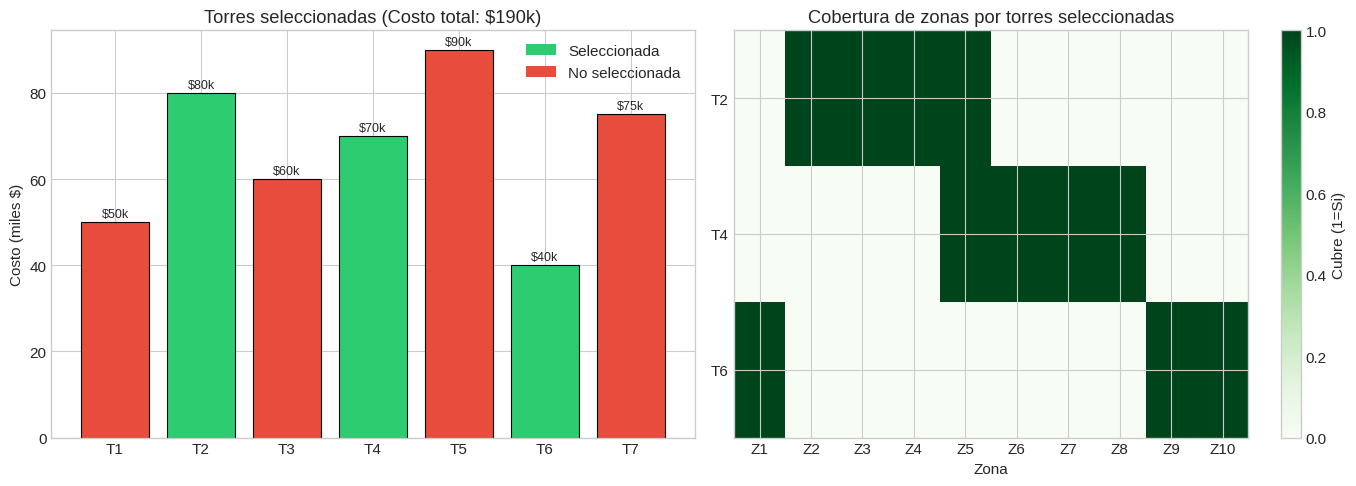

In [16]:
# === EJECUTAR Y VISUALIZAR PROBLEMA 3 ===

def plot_p3(y_opt, costo_opt):
    """Visualiza la seleccion de torres y la cobertura."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Panel 1: Torres seleccionadas y sus costos
    ax = axes[0]
    colors = ['#2ecc71' if y == 1 else '#e74c3c' for y in y_opt]
    bars = ax.bar(nombres_torres_p3, costos_torres_p3, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_ylabel('Costo (miles $)')
    ax.set_title(f'Torres seleccionadas (Costo total: ${costo_opt:.0f}k)')
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2ecc71', label='Seleccionada'),
                       Patch(facecolor='#e74c3c', label='No seleccionada')]
    ax.legend(handles=legend_elements)
    for bar, costo in zip(bars, costos_torres_p3):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'${costo}k', ha='center', va='bottom', fontsize=9)

    # Panel 2: Mapa de cobertura (torres seleccionadas x zonas)
    ax = axes[1]
    torres_sel = [i for i, y in enumerate(y_opt) if y == 1]
    cob_matrix = cobertura_p3[torres_sel, :]  # (num_sel, 10)
    im = ax.imshow(cob_matrix, cmap='Greens', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(range(n_zonas_p3))
    ax.set_xticklabels([f'Z{j+1}' for j in range(n_zonas_p3)])
    ax.set_yticks(range(len(torres_sel)))
    ax.set_yticklabels([nombres_torres_p3[i] for i in torres_sel])
    ax.set_title('Cobertura de zonas por torres seleccionadas')
    ax.set_xlabel('Zona')
    plt.colorbar(im, ax=ax, label='Cubre (1=Si)')

    plt.tight_layout()
    plt.show()


y_opt_p3, costo_opt_p3 = resolver_p3()
info_p3 = verificar_p3(y_opt_p3)

print(f"Solucion P3:")
for i, (nombre, sel) in enumerate(zip(nombres_torres_p3, y_opt_p3)):
    if sel > 0.5:
        zonas = [j+1 for j in range(n_zonas_p3) if cobertura_p3[i, j] == 1]
        print(f"  {nombre}: Construir (costo=${costos_torres_p3[i]:.0f}k, cubre zonas {zonas})")
print(f"Costo total: ${costo_opt_p3:.0f}k")
print(f"Factible: {info_p3['factible']}")
print(f"Zonas sin cubrir: {info_p3['zonas_sin_cubrir']}")

plot_p3(y_opt_p3, costo_opt_p3)


---
## Problema 4: Calibracion de sensor (4 puntos)

Un ingeniero necesita calibrar un sensor cuya respuesta sigue el modelo:

$$y(t) = a \cdot \sin(b \cdot t + c) + d \cdot e^{-0.1 \cdot t}$$

donde $a, b, c, d$ son parametros desconocidos y $t$ es la posicion del sensor.

Se tienen **20 mediciones** del sensor en posiciones conocidas (ver datos). El objetivo es encontrar los parametros $a, b, c, d$ que **minimicen el error** entre las predicciones del modelo y las mediciones observadas.

**Nota:** El paisaje de error tiene **multiples minimos locales** debido a los terminos trigonometricos.

**Cotas de los parametros:** $a \in [0, 5]$, $b \in [0, 10]$, $c \in [0, 2\pi]$, $d \in [-3, 3]$

### 4.1 Formulacion matematica

**Variables de decision:**

$$\boldsymbol{\theta} = (a, b, c, d)$$

donde $a \in [0,5]$, $b \in [0,10]$, $c \in [0, 2\pi]$, $d \in [-3,3]$ son los parámetros del modelo del sensor.

**Funcion objetivo:**

$$\min_{a,b,c,d} \quad \sum_{k=1}^{20} \left[ y_k - \left( a \sin(b t_k + c) + d e^{-0.1 t_k} \right) \right]^2$$

**Restricciones:**

$$\begin{aligned}
& a \in [0, 5], \quad b \in [0, 10], \quad c \in [0, 2\pi], \quad d \in [-3, 3]
\end{aligned}$$


### 4.2 Eleccion de optimizador

**Optimizador elegido:** `scipy.optimize.differential_evolution`

**Justificacion:** La función objetivo tiene múltiples mínimos locales debido a los términos trigonométricos ($\sin(bt+c)$), lo que hace que los métodos de gradiente locales (como BFGS o Nelder-Mead) queden atrapados en soluciones subóptimas dependiendo del punto inicial. `differential_evolution` es un algoritmo metaheurístico evolutivo que explora el espacio de búsqueda globalmente con una población de soluciones candidatas, siendo muy robusto para funciones multimodales dentro de cotas acotadas.

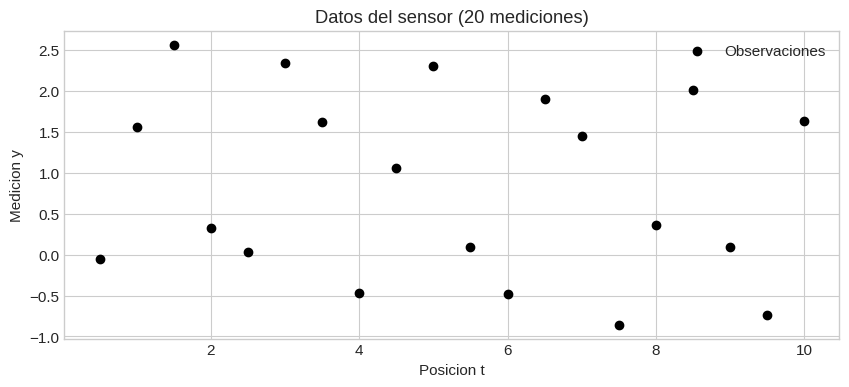

In [20]:
# === DATOS PROBLEMA 4 (NO MODIFICAR) ===

def modelo_sensor(t, params):
    """Modelo del sensor: y = a*sin(b*t + c) + d*exp(-0.1*t)

    Args:
        t: np.array -- posiciones
        params: np.array (4,) -- [a, b, c, d]

    Returns:
        np.array -- predicciones del modelo
    """
    a, b, c, d = params
    return a * np.sin(b * t + c) + d * np.exp(-0.1 * t)

# Posiciones de medicion
t_obs_p4 = np.linspace(0.5, 10.0, 20)

# Mediciones observadas (generadas con parametros ocultos + ruido)
_rng_p4 = np.random.default_rng(2026)
_params_ocultos = _rng_p4.uniform([1, 1, 0, 0.5], [4, 5, 2*np.pi, 3])
y_obs_p4 = modelo_sensor(t_obs_p4, _params_ocultos) + _rng_p4.normal(0, 0.2, 20)
del _rng_p4, _params_ocultos

bounds_p4 = [(0, 5), (0, 10), (0, 2*np.pi), (-3, 3)]

# Visualizar los datos
plt.figure(figsize=(10, 4))
plt.scatter(t_obs_p4, y_obs_p4, color="black", zorder=5, label="Observaciones")
plt.xlabel("Posicion t"); plt.ylabel("Medicion y")
plt.title("Datos del sensor (20 mediciones)")
plt.legend(); plt.show()

In [21]:
# === IMPLEMENTACION PROBLEMA 4 ===

def objetivo_p4(params):
    """Calcula el error cuadratico entre el modelo y las observaciones."""
    y_pred = modelo_sensor(t_obs_p4, params)
    return float(np.sum((y_obs_p4 - y_pred) ** 2))


def resolver_p4():
    """Resuelve el problema de calibracion."""
    res = differential_evolution(
        objetivo_p4,
        bounds=bounds_p4,
        seed=42,
        maxiter=2000,
        popsize=20,
        tol=1e-10,
        mutation=(0.5, 1.5),
        recombination=0.9,
        workers=1
    )
    return res.x, res.fun


Solucion P4:
  a = 1.5090
  b = 3.5530
  c = 2.9058
  d = 1.4254
Error: 0.088386


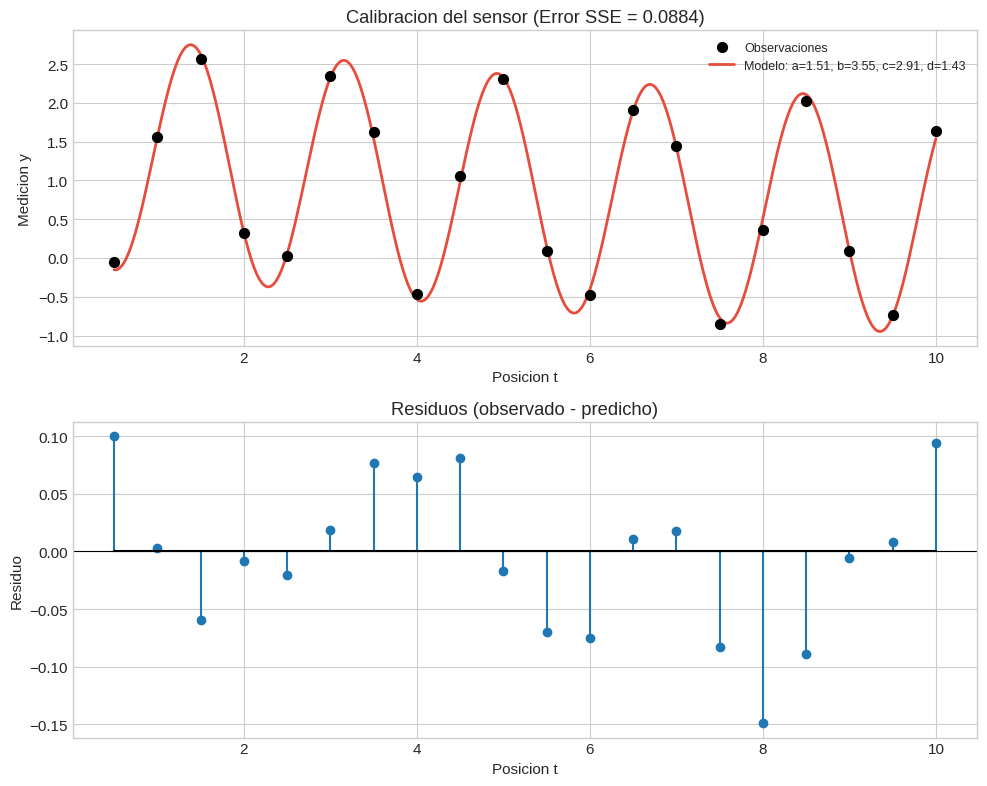

In [22]:
# === EJECUTAR Y VISUALIZAR PROBLEMA 4 ===

def plot_p4(params_opt, error_opt):
    """Visualiza el ajuste del modelo a los datos."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    t_fine = np.linspace(t_obs_p4.min(), t_obs_p4.max(), 300)
    y_model = modelo_sensor(t_fine, params_opt)
    y_pred_obs = modelo_sensor(t_obs_p4, params_opt)
    residuos = y_obs_p4 - y_pred_obs

    # Panel 1: Datos vs modelo
    ax = axes[0]
    ax.scatter(t_obs_p4, y_obs_p4, color='black', zorder=5, label='Observaciones', s=50)
    ax.plot(t_fine, y_model, color='#e74c3c', linewidth=2,
            label=f'Modelo: a={params_opt[0]:.2f}, b={params_opt[1]:.2f}, c={params_opt[2]:.2f}, d={params_opt[3]:.2f}')
    ax.set_xlabel('Posicion t')
    ax.set_ylabel('Medicion y')
    ax.set_title(f'Calibracion del sensor (Error SSE = {error_opt:.4f})')
    ax.legend(fontsize=9)

    # Panel 2: Residuos
    ax = axes[1]
    ax.stem(t_obs_p4, residuos, linefmt='C0-', markerfmt='C0o', basefmt='k-')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Posicion t')
    ax.set_ylabel('Residuo')
    ax.set_title('Residuos (observado - predicho)')

    plt.tight_layout()
    plt.show()


params_opt_p4, error_opt_p4 = resolver_p4()

print(f"Solucion P4:")
print(f"  a = {params_opt_p4[0]:.4f}")
print(f"  b = {params_opt_p4[1]:.4f}")
print(f"  c = {params_opt_p4[2]:.4f}")
print(f"  d = {params_opt_p4[3]:.4f}")
print(f"Error: {error_opt_p4:.6f}")

plot_p4(params_opt_p4, error_opt_p4)


---
## Problema 5: Red de distribucion (4 puntos)

Una empresa de logistica considera abrir centros de distribucion (CDs) en **4 ciudades** posibles para atender a **6 clientes**. Cada CD tiene un **costo fijo** de apertura, una **capacidad maxima**, y un **costo de envio por unidad** a cada cliente. Cada cliente tiene una **demanda** que debe ser satisfecha completamente.

La empresa debe decidir:
1. **Que CDs abrir** (decision binaria: abrir o no)
2. **Cuantas unidades enviar** de cada CD abierto a cada cliente (decision continua)

El objetivo es **minimizar el costo total** (costos fijos de apertura + costos de envio).

| CD | Ciudad      | Costo fijo (miles \$) | Capacidad |
|:--:|:-----------:|:--------------------:|:---------:|
| 1  | Guadalajara | 800                  | 500       |
| 2  | Monterrey   | 700                  | 400       |
| 3  | CDMX        | 1000                 | 600       |
| 4  | Merida      | 600                  | 350       |

| Cliente | C1  | C2 | C3  | C4  | C5  | C6  |
|:-------:|:---:|:--:|:---:|:---:|:---:|:---:|
| Demanda | 120 | 80 | 200 | 150 | 100 | 180 |

**Costos de envio** (\$ por unidad):

|      | C1 | C2 | C3 | C4 | C5 | C6 |
|:----:|:--:|:--:|:--:|:--:|:--:|:--:|
| GDL  | 4  | 8  | 5  | 9  | 7  | 6  |
| MTY  | 7  | 3  | 6  | 8  | 4  | 9  |
| CDMX | 5  | 6  | 3  | 4  | 8  | 5  |
| MER  | 9  | 7  | 8  | 3  | 6  | 4  |

### 5.1 Formulacion matematica

**Variables de decision:**

$$y_i \in \{0,1\} \quad i=1,\ldots,4 \qquad x_{ij} \geq 0 \quad i=1,\ldots,4,\; j=1,\ldots,6$$

donde $y_i = 1$ si el CD $i$ se abre, y $x_{ij}$ es el número de unidades enviadas del CD $i$ al cliente $j$.

**Funcion objetivo:**

$$\min_{\mathbf{y}, X} \quad \sum_{i=1}^{4} f_i \, y_i + \sum_{i=1}^{4} \sum_{j=1}^{6} c_{ij} \, x_{ij}$$

**Restricciones:**

$$\begin{aligned}
& \sum_{i=1}^{4} x_{ij} = d_j \quad \forall j \quad \text{(demanda de cada cliente satisfecha)} \\
& \sum_{j=1}^{6} x_{ij} \leq C_i \, y_i \quad \forall i \quad \text{(capacidad y solo si abierto)} \\
& y_i \in \{0,1\}, \quad x_{ij} \geq 0
\end{aligned}$$


### 5.2 Eleccion de optimizador

**Optimizador elegido:** `scipy.optimize.milp` (Mixed Integer Linear Programming)

**Justificacion:** El problema de ubicación de instalaciones (Facility Location Problem) es un MILP clásico: las variables $y_i$ son binarias y las $x_{ij}$ son continuas; la función objetivo y las restricciones son todas lineales. `milp` de SciPy resuelve esto exactamente mediante Branch-and-Bound con relajación LP, garantizando el óptimo global. Los métodos heurísticos o de optimización continua no pueden manejar directamente la integrality de las $y_i$.

In [23]:
# === DATOS PROBLEMA 5 (NO MODIFICAR) ===
ciudades_p5 = ["Guadalajara", "Monterrey", "CDMX", "Merida"]
n_cds_p5 = 4
n_clientes_p5 = 6

costos_fijos_p5 = np.array([800, 700, 1000, 600])    # miles $
capacidades_p5 = np.array([500, 400, 600, 350])
demandas_p5 = np.array([120, 80, 200, 150, 100, 180])

# costos_envio_p5[i, j] = costo de enviar 1 unidad de CD i a cliente j
costos_envio_p5 = np.array([
    [4, 8, 5, 9, 7, 6],   # Guadalajara
    [7, 3, 6, 8, 4, 9],   # Monterrey
    [5, 6, 3, 4, 8, 5],   # CDMX
    [9, 7, 8, 3, 6, 4],   # Merida
])

In [ ]:
# === IMPLEMENTACION PROBLEMA 5 ===

def objetivo_p5(y, X):
    """Calcula el costo total: costos fijos + costos de envio."""
    costo_fijo = float(costos_fijos_p5 @ y)
    costo_envio = float(np.sum(costos_envio_p5 * X))
    return costo_fijo + costo_envio


def verificar_p5(y, X):
    """Verifica si la solucion cumple todas las restricciones."""
    demanda_cumplida = X.sum(axis=0)  # (6,)
    capacidad_usada = X.sum(axis=1)   # (4,)
    demanda_ok = np.allclose(demanda_cumplida, demandas_p5, atol=1e-4)
    cap_ok = np.all(capacidad_usada <= capacidades_p5 * y + 1e-4)
    x_ok = np.all(X >= -1e-6)
    factible = demanda_ok and cap_ok and x_ok
    return {
        'factible': factible,
        'demanda_cumplida': demanda_cumplida,
        'capacidad_usada': capacidad_usada
    }


def resolver_p5():
    """Resuelve el problema de red de distribucion."""
    from scipy.optimize import milp, LinearConstraint, Bounds

    m = n_cds_p5      # 4 CDs
    n = n_clientes_p5  # 6 clientes


    # Orden: primero las y (4), luego x aplanado en fila (4*6=24)

    n_vars = m + m * n  # 28

    # Funcion objetivo
    c_obj = np.concatenate([costos_fijos_p5.astype(float),
                             costos_envio_p5.flatten().astype(float)])


    # Demanda: sum_i x_ij = d_j  => n restricciones de igualdad
    #    Para cliente j: sum_i x[i,j]
    A_demanda = np.zeros((n, n_vars))
    for j in range(n):
        for i in range(m):
            col = m + i * n + j  # x[i,j] en el vector
            A_demanda[j, col] = 1.0

    # Capacidad: sum_j x_ij <= C_i * y_i  => sum_j x_ij - C_i * y_i <= 0
    A_cap = np.zeros((m, n_vars))
    for i in range(m):
        A_cap[i, i] = -capacidades_p5[i]  # -C_i * y_i
        for j in range(n):
            col = m + i * n + j
            A_cap[i, col] = 1.0  # x_ij

    # Combinar todas las restricciones
    A_all = np.vstack([A_demanda, A_cap])
    lb_all = np.concatenate([demandas_p5.astype(float), -np.inf * np.ones(m)])
    ub_all = np.concatenate([demandas_p5.astype(float), np.zeros(m)])

    constraint = LinearConstraint(A_all, lb=lb_all, ub=ub_all)

    # Bounds
    lb_vars = np.zeros(n_vars)
    ub_vars = np.concatenate([np.ones(m), np.full(m * n, np.inf)])
    bounds = Bounds(lb=lb_vars, ub=ub_vars)

    # y son enteras (1), x son continuas (0)
    integrality = np.concatenate([np.ones(m), np.zeros(m * n)])

    res = milp(c_obj, constraints=constraint, integrality=integrality, bounds=bounds)

    sol = res.x
    y_opt = np.round(sol[:m]).astype(int)
    X_opt = sol[m:].reshape(m, n)
    costo_opt = objetivo_p5(y_opt, X_opt)

    return y_opt, X_opt, costo_opt


Solucion P5:
  CDMX: ABIERTO (480/600 unidades)
    -> Cliente C1: 120 unidades
    -> Cliente C2: 80 unidades
    -> Cliente C3: 200 unidades
    -> Cliente C4: 80 unidades
  Merida: ABIERTO (350/350 unidades)
    -> Cliente C4: 70 unidades
    -> Cliente C5: 100 unidades
    -> Cliente C6: 180 unidades
Costo total: $5130k
Factible: True


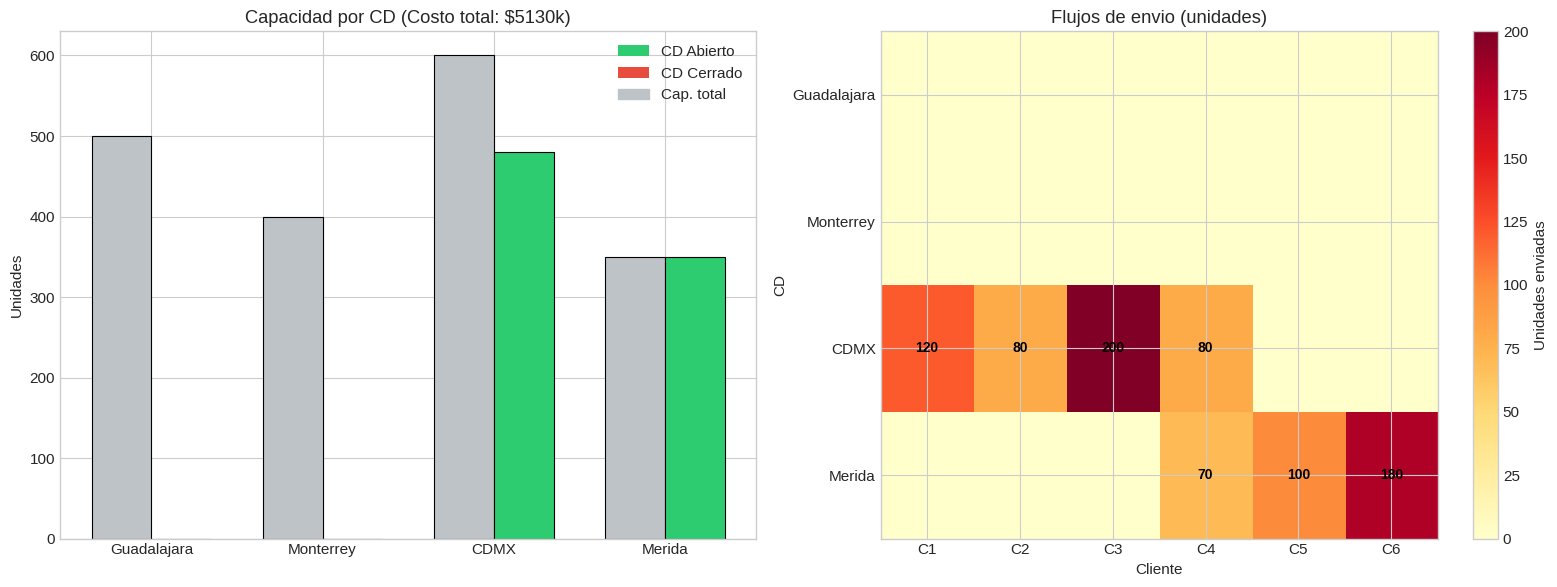

In [25]:
# === EJECUTAR Y VISUALIZAR PROBLEMA 5 ===

def plot_p5(y_opt, X_opt, costo_opt):
    """Visualiza la red de distribucion."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Panel 1: Capacidad usada vs disponible por CD
    ax = axes[0]
    cap_usada = X_opt.sum(axis=1)
    x_pos = np.arange(m := n_cds_p5)
    width = 0.35
    colors_cd = ['#2ecc71' if y == 1 else '#e74c3c' for y in y_opt]
    bars1 = ax.bar(x_pos - width/2, capacidades_p5, width, label='Capacidad total',
                   color='#bdc3c7', edgecolor='black', linewidth=0.8)
    bars2 = ax.bar(x_pos + width/2, cap_usada, width, label='Capacidad usada',
                   color=colors_cd, edgecolor='black', linewidth=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ciudades_p5)
    ax.set_ylabel('Unidades')
    ax.set_title(f'Capacidad por CD (Costo total: ${costo_opt:.0f}k)')
    ax.legend()
    from matplotlib.patches import Patch
    open_patch = Patch(facecolor='#2ecc71', label='CD Abierto')
    closed_patch = Patch(facecolor='#e74c3c', label='CD Cerrado')
    ax.legend(handles=[open_patch, closed_patch,
                        plt.Rectangle((0,0),1,1, color='#bdc3c7', label='Cap. total')])

    # Panel 2: Heatmap de flujos
    ax = axes[1]
    im = ax.imshow(X_opt, cmap='YlOrRd', aspect='auto')
    ax.set_xticks(range(n_clientes_p5))
    ax.set_xticklabels([f'C{j+1}' for j in range(n_clientes_p5)])
    ax.set_yticks(range(n_cds_p5))
    ax.set_yticklabels(ciudades_p5)
    ax.set_title('Flujos de envio (unidades)')
    ax.set_xlabel('Cliente')
    ax.set_ylabel('CD')
    for i in range(n_cds_p5):
        for j in range(n_clientes_p5):
            if X_opt[i, j] > 0.1:
                ax.text(j, i, f'{X_opt[i,j]:.0f}', ha='center', va='center',
                        fontsize=10, color='black', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Unidades enviadas')

    plt.tight_layout()
    plt.show()


y_opt_p5, X_opt_p5, costo_opt_p5 = resolver_p5()
info_p5 = verificar_p5(y_opt_p5, X_opt_p5)

print(f"Solucion P5:")
for i, (ciudad, abierto) in enumerate(zip(ciudades_p5, y_opt_p5)):
    if abierto > 0.5:
        cap_usada = X_opt_p5[i].sum()
        print(f"  {ciudad}: ABIERTO ({cap_usada:.0f}/{capacidades_p5[i]} unidades)")
        for j in range(n_clientes_p5):
            if X_opt_p5[i, j] > 0.1:
                print(f"    -> Cliente C{j+1}: {X_opt_p5[i, j]:.0f} unidades")
print(f"Costo total: ${costo_opt_p5:.0f}k")
print(f"Factible: {info_p5['factible']}")

plot_p5(y_opt_p5, X_opt_p5, costo_opt_p5)
